In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

/anaconda2/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
import shap
from sklearn.ensemble import RandomForestClassifier

In [4]:
from mlfinlab.microstructural_features import get_roll_measure, get_roll_impact
from mlfinlab.microstructural_features import get_corwin_schultz_estimator, get_bekker_parkinson_vol
from mlfinlab.microstructural_features import get_bar_based_kyle_lambda, get_bar_based_amihud_lambda, get_bar_based_hasbrouck_lambda
from ta import add_all_ta_features
from ta.utils import dropna

In [5]:
from mlfinlab.backtest_statistics import sharpe_ratio
from mlfinlab.backtest_statistics import probabilistic_sharpe_ratio
from mlfinlab.backtest_statistics import deflated_sharpe_ratio
from mlfinlab.backtest_statistics import information_ratio
from mlfinlab.backtest_statistics import minimum_track_record_length
from mlfinlab.backtest_statistics import drawdown_and_time_under_water

In [6]:
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [7]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [8]:
def create_model():
    clf=RandomForestClassifier(n_estimators=1,
                               criterion='entropy',
                               bootstrap=False,
                               class_weight='balanced_subsample')
    clf=BaggingClassifier(base_estimator=clf,
                         n_estimators=100,
                         max_features=1.)
    return clf

In [9]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(252))

def calculate_all_metrics(benchmark_returns, strategy_returns, dates_array):
    
    res = {}
    
    benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
    benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
    strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
    strategy_sharpe_smart = smart_sharpe(strategy_returns)
    psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
    all_strategy_sharpes = []
    for r in bagging_returns:
        sr_i = sharpe_ratio(r, entries_per_year=252)
        all_strategy_sharpes.append(sr_i)
    dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
    ir = information_ratio(strategy_returns, benchmark=np.mean(benchmark_returns), entries_per_year=252)
    mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)

    res['benchmark_mean_returns'] = np.mean(benchmark_returns)
    res['strategy_mean_returns'] = np.mean(strategy_returns) 
    res['benchmark_sharpe'] = benchmark_sharpe
    res['benchmark_sharpe_smart'] = benchmark_sharpe_smart
    res['strategy_sharpe'] = strategy_sharpe
    res['strategy_sharpe_smart'] = strategy_sharpe_smart
    res['probabilistic_sharpe_ratio'] = psr
    res['deflated_sharpe_ratio'] = dsr
    res['information_ratio'] = ir
    res['minimum_track_record_length'] = mtrl

    return res

def calculate_important_features(dataset_train, dataset_test, cutoff_up = 0, cutoff_down = 3, visualize = False):

    X_train, Y_train, P_train, T_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
    X_test, Y_test, P_test, T_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])
    X_train_df = pd.DataFrame(X_train, columns = FEATURE_COLUMNS)
    X_test_df = pd.DataFrame(X_test, columns = FEATURE_COLUMNS)
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', criterion='entropy')
    clf.fit(X_train_df, Y_train)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_train_df)
    fi0 = np.abs(shap_values[0]).mean(axis=0)
    fi1 = np.abs(shap_values[1]).mean(axis=0)
    fi = fi0 + fi1
    imp = pd.DataFrame({
        'feature': X_train_df.columns.tolist(),
        'mean': fi
    })
    imp = imp.set_index('feature')
    
    if visualize:
        imp.sort_values('mean').plot.barh()
        
    return imp, imp.sort_values('mean')[::-1][cutoff_up:-cutoff_down].index.values.tolist()

In [10]:
def createXY(inputs, outputs, training=False): 
    
    def flatten_features_window(x):
        mean = x.mean(axis=1)
        std = x.std(axis=1)
        low = x.min(axis=1)
        high = x.max(axis=1)
        open_f = x[:, 0]
        close_f = x[:, -1]
        return close_f
    
    X, Y, P, T = [], [], [], []
    
    # FIXED IID ASSUMPTION (up to some point)
    if training:
        SKIP = WINDOW + HORIZON
    else:
        SKIP = 1
    
    for i in range(INPUT_WINDOW, len(inputs)-HORIZON, SKIP):

        if INPUT_WINDOW > 1:
            window = inputs[i-INPUT_WINDOW:i].values
        else:
            window = inputs.iloc[i].values
        future = (outputs[i+HORIZON] - outputs[i]) / outputs[i]
        future_binary = 1.0 if future > 0 else 0.0

        X.append(window)
        Y.append(future_binary)
        P.append(future)
        T.append(outputs.index[i+HORIZON])

    X, Y, P = np.array(X), np.array(Y), np.array(P)
    
    if INPUT_WINDOW > 1:
        X = flatten_features_window(X)
    return X, Y, P, T

# Data reading

In [11]:
from yahoofinancials import YahooFinancials

In [12]:
TICKER = 'C'

In [13]:
aapl_yf = yahoo_financials_tech = YahooFinancials([TICKER])
data = aapl_yf.get_historical_price_data('2000-01-01', '2020-08-01', 'daily')

In [14]:
data = pd.DataFrame(data[TICKER]['prices'])
data = data.set_index('formatted_date')
data = data.dropna()

# Data Preparation

In [15]:
try:
    frac_diff_series = frac_diff_ffd(pd.DataFrame(np.log(data['close'])), 0.7, thresh=1e-4)
except:
    print('Not calculated')
    frac_diff_series = pd.DataFrame(np.log(data['close'])).pct_change()

In [16]:
WINDOW = 14
INPUT_WINDOW = 1 # REDUCED THE CONTEXT
HORIZON = 1
N_SAMPLES = 25

In [17]:
# Add all ta features
technical_features = add_all_ta_features(
    data, open="open", high="high", low="low", close="close", volume="volume")

In [18]:
data['feat_tech_volume_cmf'] = technical_features['volume_cmf']
data['feat_tech_volatility_dcl'] = technical_features['volatility_dcl']
data['feat_tech_trend_macd_diff'] = technical_features['trend_macd_diff']
data['feat_tech_trend_vortex_ind_diff'] = technical_features['trend_vortex_ind_diff']
data['feat_tech_momentum_stoch_signal'] = technical_features['momentum_stoch_signal']
data['feat_tech_momentum_tsi'] = technical_features['momentum_tsi']

In [19]:
data['feat_afml_roll_measure'] = get_roll_measure(data['close'], WINDOW)
data['feat_afml_roll_impact'] = get_roll_impact(data['close'], data['volume'], WINDOW)
data['feat_afml_corwin_schultz'] = get_corwin_schultz_estimator(data['high'], data['low'], WINDOW)
data['feat_afml_bekker_parkinson_vol'] = get_bekker_parkinson_vol(data['high'], data['low'], WINDOW)
data['feat_afml_kyle_lambda'] = get_bar_based_kyle_lambda(data['close'], data['volume'], WINDOW)
data['feat_afml_amihud_lambda'] = get_bar_based_amihud_lambda(data['close'], data['volume'], WINDOW)
data['feat_afml_hasbrouck_lambda'] = get_bar_based_hasbrouck_lambda(data['close'], data['volume'], WINDOW)

In [20]:
data['feat_stat_min_frac_close'] = frac_diff_series.rolling(WINDOW).min()
data['feat_stat_max_frac_close'] = frac_diff_series.rolling(WINDOW).max()
data['feat_stat_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
data['feat_stat_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
data['feat_stat_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
data['feat_stat_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
data['feat_stat_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)

In [21]:
FEATURE_COLUMNS = [d for d in data.columns if 'feat_' in d]
dataset = data[FEATURE_COLUMNS]

In [22]:
dataset_normalized = {}
for feature_column in dataset.columns:
    feature_i = dataset[feature_column]
    feature_i_norm = (feature_i - feature_i.rolling(WINDOW).mean()) / feature_i.rolling(WINDOW).std()
    dataset_normalized[feature_column] = feature_i_norm
dataset_normalized = pd.DataFrame(
       dataset_normalized, index = dataset.index
)

In [23]:
dataset = dataset_normalized

In [24]:
dataset['close'] = data['close']
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

# Modeling

In [25]:
def train_and_evaluate_n_times(X_train, Y_train, X_test, Y_test):
    mmcs, pred_prs = [], []
    for n in range(N_SAMPLES):

        clf = create_model()

        clf.fit(X_train, Y_train)
        pred = clf.predict(X_test)
        pred_pr = clf.predict_proba(X_test)[:, 1]

        mmcs.append(matthews_corrcoef(Y_test, pred))
        pred_prs.append(pred_pr)
    return mmcs, pred_prs

def visualize_mmcs(mmcs):
    plt.figure()
    plt.title(str(np.mean(mmcs)))
    plt.hist(mmcs)
    plt.axvline(np.mean(mmcs), color = 'red')
    plt.show()
    
def backtest_predictions(pred_prs, P_test):
    bagging_strategies, bagging_returns = [], []
    for pred_pr in pred_prs:
        signal = [-(1-p) if p <= 0.5 else p for p in pred_pr]
        bagging_strategies.append((signal * P_test).cumsum())
        bagging_returns.append(signal * P_test)
    return bagging_strategies, bagging_returns

def visualize_backtests(bagging_strategies, P_test):
    plt.figure(figsize = (15, 5))
    for strategy in bagging_strategies:
        plt.plot(strategy, color = 'grey', ls = '--', lw=0.5)
    plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
    plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')
    plt.legend()
    plt.show()

In [26]:
%%time

START_YEAR, END_YEAR = 2000, 2021
TRAIN_YEARS = 5
TRADE_YEARS = 3

ALL_P_TESTS = []
ALL_RETURNS = []
ALL_DATES = []
ALL_MMCS, ALL_PREDS = [], []
FEATURE_IMPORTANCES = []

for i in range(START_YEAR, END_YEAR-TRAIN_YEARS, TRADE_YEARS):
    print(i, i+TRAIN_YEARS, i+TRAIN_YEARS+TRADE_YEARS)
    dataset_train = dataset[str(i):str(i+TRAIN_YEARS)]
    dataset_test = dataset[str(i+TRAIN_YEARS):str(i+TRAIN_YEARS+TRADE_YEARS)]
    imp, IMPORTANT_FEATURES = calculate_important_features(dataset_train, dataset_test)
    X_train, Y_train, P_train, T_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
    X_test, Y_test, P_test, T_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])
    mmcs, pred_prs = train_and_evaluate_n_times(X_train, Y_train, X_test, Y_test)
    bagging_strategies, bagging_returns = backtest_predictions(pred_prs, P_test)
    ALL_RETURNS.append(np.array(bagging_returns))
    ALL_P_TESTS.extend(P_test)
    ALL_DATES.extend(T_test)
    ALL_MMCS.append(mmcs)
    ALL_PREDS.append(pred_prs)
    FEATURE_IMPORTANCES.append(imp)

2000 2005 2008
2003 2008 2011
2006 2011 2014
2009 2014 2017
2012 2017 2020
2015 2020 2023
CPU times: user 3min 4s, sys: 3.26 s, total: 3min 7s
Wall time: 3min 32s


In [27]:
ALL_DATES = [datetime.strptime(date, "%Y-%m-%d").date() for date in ALL_DATES]

In [28]:
ALL_RETURNS = np.concatenate((
    ALL_RETURNS
), axis=1)
ALL_PREDS = np.concatenate((
    ALL_PREDS
), axis=1)

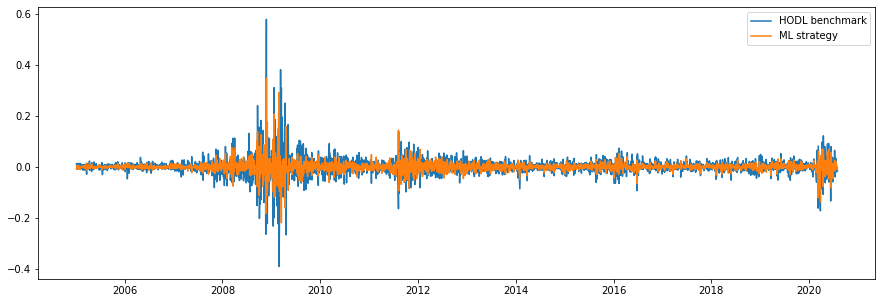

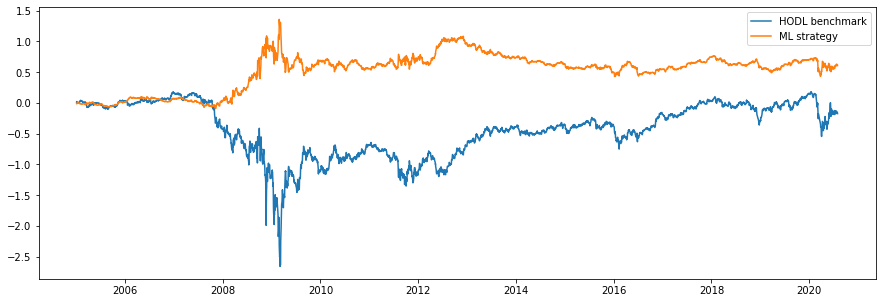

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(ALL_DATES, ALL_P_TESTS, label = 'HODL benchmark')
plt.plot(ALL_DATES, np.array(ALL_RETURNS).mean(axis=0), label = 'ML strategy')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(ALL_DATES, np.array(ALL_P_TESTS).cumsum(), label = 'HODL benchmark')
plt.plot(ALL_DATES, np.array(ALL_RETURNS).mean(axis=0).cumsum(), label = 'ML strategy')
plt.legend()
plt.show()

In [30]:
%%time

ALL_P_TESTS = []
ALL_RETURNS_IMPORTANT = []
ALL_DATES = []
ALL_MMCS_IMPORTANT, ALL_PREDS_IMPORTANT = [], []
FEATURE_IMPORTANCES_IMPORTANT = []

for i in range(START_YEAR, END_YEAR-TRAIN_YEARS, TRADE_YEARS):
    print(i, i+TRAIN_YEARS, i+TRAIN_YEARS+TRADE_YEARS)
    dataset_train = dataset[str(i):str(i+TRAIN_YEARS)]
    dataset_test = dataset[str(i+TRAIN_YEARS):str(i+TRAIN_YEARS+TRADE_YEARS)]
    imp, IMPORTANT_FEATURES = calculate_important_features(dataset_train, dataset_test)
    X_train, Y_train, P_train, T_train = createXY(dataset_train[IMPORTANT_FEATURES], dataset_train['close'], training=True)
    X_test, Y_test, P_test, T_test = createXY(dataset_test[IMPORTANT_FEATURES], dataset_test['close'])
    mmcs, pred_prs = train_and_evaluate_n_times(X_train, Y_train, X_test, Y_test)
    bagging_strategies, bagging_returns = backtest_predictions(pred_prs, P_test)
    ALL_RETURNS_IMPORTANT.append(np.array(bagging_returns))
    ALL_P_TESTS.extend(P_test)
    ALL_DATES.extend(T_test)
    ALL_MMCS_IMPORTANT.append(mmcs)
    ALL_PREDS_IMPORTANT.append(pred_prs)
    FEATURE_IMPORTANCES_IMPORTANT.append(imp)

2000 2005 2008
2003 2008 2011
2006 2011 2014
2009 2014 2017
2012 2017 2020
2015 2020 2023
CPU times: user 3min 1s, sys: 3.54 s, total: 3min 4s
Wall time: 3min 26s


In [31]:
ALL_DATES = [datetime.strptime(date, "%Y-%m-%d").date() for date in ALL_DATES]

In [32]:
ALL_RETURNS_IMPORTANT = np.concatenate((
    ALL_RETURNS_IMPORTANT
), axis=1)
ALL_PREDS_IMPORTANT = np.concatenate((
    ALL_PREDS_IMPORTANT
), axis=1)

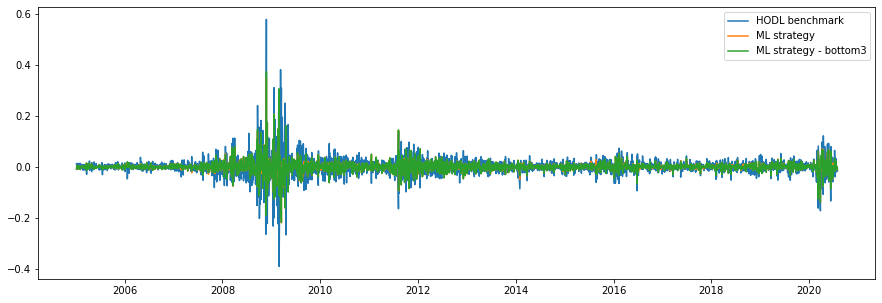

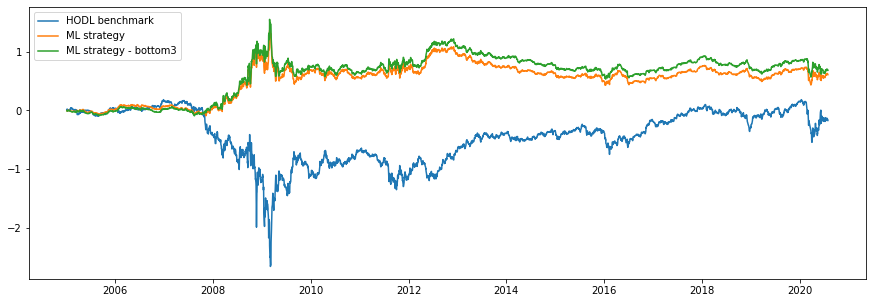

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(ALL_DATES, ALL_P_TESTS, label = 'HODL benchmark')
plt.plot(ALL_DATES, np.array(ALL_RETURNS).mean(axis=0), label = 'ML strategy')
plt.plot(ALL_DATES, ALL_RETURNS_IMPORTANT.mean(axis=0), label = 'ML strategy - bottom3')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(ALL_DATES, np.array(ALL_P_TESTS).cumsum(), label = 'HODL benchmark')
plt.plot(ALL_DATES, np.array(ALL_RETURNS).mean(axis=0).cumsum(), label = 'ML strategy')
plt.plot(ALL_DATES, np.array(ALL_RETURNS_IMPORTANT.mean(axis=0)).cumsum(), label = 'ML strategy - bottom3')
plt.legend()
plt.show()

In [34]:
def calculate_all_metrics(benchmark_returns, strategy_returns, dates_array, mmcs, pred_prs):
    
    res = {}
    strategy_returns_mean = strategy_returns.mean(axis=0)
    
    benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
    benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
    strategy_sharpe = sharpe_ratio(strategy_returns_mean, entries_per_year=252)
    strategy_sharpe_smart = smart_sharpe(strategy_returns_mean)
    psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
    all_strategy_sharpes = []
    for r in strategy_returns:
        sr_i = sharpe_ratio(r, entries_per_year=252)
        all_strategy_sharpes.append(sr_i)
    dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
    ir = information_ratio(strategy_returns_mean, benchmark=np.mean(benchmark_returns), entries_per_year=252)
    mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)
    
    df_for_ddn = pd.DataFrame.from_dict({'Date': ALL_DATES, 
                                         'Benchmark': benchmark_returns,
                                         'Strategy': strategy_returns_mean})
    df_for_ddn = df_for_ddn.set_index('Date')
    df_for_ddn['Cumulative_Benchmark'] = df_for_ddn.Benchmark.cumsum().round(2)
    df_for_ddn['Cumulative_Strategy'] = df_for_ddn.Strategy.cumsum().round(2)
    df_for_ddn['HighValue_Benchmark'] = df_for_ddn['Cumulative_Benchmark'].cummax()
    df_for_ddn['HighValue_Strategy'] = df_for_ddn['Cumulative_Strategy'].cummax()
    df_for_ddn['Drawdown_Benchmark'] = df_for_ddn['Cumulative_Benchmark'] - df_for_ddn['HighValue_Benchmark']
    df_for_ddn['Drawdown_Strategy'] = df_for_ddn['Cumulative_Strategy'] - df_for_ddn['HighValue_Strategy']

    res['benchmark_mean_returns'] = np.mean(benchmark_returns)
    res['strategy_mean_returns'] = np.mean(strategy_returns) 
    res['benchmark_sharpe'] = benchmark_sharpe
    res['benchmark_sharpe_smart'] = benchmark_sharpe_smart
    res['strategy_sharpe'] = strategy_sharpe
    res['strategy_sharpe_smart'] = strategy_sharpe_smart
    res['probabilistic_sharpe_ratio'] = psr
    res['deflated_sharpe_ratio'] = dsr
    res['information_ratio'] = ir
    res['minimum_track_record_length'] = mtrl
    res['benchmark_drawdown'] = df_for_ddn['Drawdown_Benchmark'].quantile(.05)
    res['strategy_drawdown'] = df_for_ddn['Drawdown_Strategy'].quantile(.05)
    res['mmc_mean'] = np.mean(mmcs)
    res['mmc_std'] = np.std(mmcs)
    res['mmc_sharpe'] = res['mmc_mean'] / res['mmc_std']
    res['model_certainty'] = abs(np.array(np.mean(pred_prs)) - 0.5) / 0.5

    return res

In [35]:
calculate_all_metrics(np.array(ALL_P_TESTS), 
                      np.array(ALL_RETURNS), 
                      ALL_DATES, ALL_MMCS, 
                      ALL_PREDS)

{'benchmark_mean_returns': -4.6506660057426554e-05,
 'strategy_mean_returns': 0.00016232534004841006,
 'benchmark_sharpe': -0.021806987162333098,
 'benchmark_sharpe_smart': -0.020932175658022318,
 'strategy_sharpe': 0.1296875931125256,
 'strategy_sharpe_smart': 0.12906310367844945,
 'probabilistic_sharpe_ratio': 1.0,
 'deflated_sharpe_ratio': 4.4513081763035496e-05,
 'information_ratio': 0.16684344816726557,
 'minimum_track_record_length': 119.87683175421891,
 'benchmark_drawdown': -1.3399999999999999,
 'strategy_drawdown': -0.8400000000000001,
 'mmc_mean': -1.4686887727424214e-05,
 'mmc_std': 0.03923538488242947,
 'mmc_sharpe': -0.00037432760686390893,
 'model_certainty': 0.04410890612463214}

In [36]:
calculate_all_metrics(
    np.array(ALL_RETURNS.mean(axis=0)), 
    np.array(ALL_RETURNS_IMPORTANT), 
    ALL_DATES,
    ALL_MMCS_IMPORTANT, 
    ALL_PREDS_IMPORTANT)

{'benchmark_mean_returns': 0.00016232534004841003,
 'strategy_mean_returns': 0.00018207413466339494,
 'benchmark_sharpe': 0.1296875931125256,
 'benchmark_sharpe_smart': 0.12906310367844945,
 'strategy_sharpe': 0.14070013546232268,
 'strategy_sharpe_smart': 0.13838037775523757,
 'probabilistic_sharpe_ratio': 0.748567969930631,
 'deflated_sharpe_ratio': 0.1370190570747889,
 'information_ratio': 0.015261135705425423,
 'minimum_track_record_length': 22530.780272612523,
 'benchmark_drawdown': -0.8400000000000001,
 'strategy_drawdown': -0.92,
 'mmc_mean': 0.0009487550224305763,
 'mmc_std': 0.03173542744104452,
 'mmc_sharpe': 0.029895769458063732,
 'model_certainty': 0.041844129446375944}

In [37]:
column_importance_ts = {}
for fi in FEATURE_IMPORTANCES:
    for column in fi.T.columns:
        if column not in column_importance_ts:
            column_importance_ts[column] = [fi.T[column]['mean']]
        else:
            column_importance_ts[column].append(fi.T[column]['mean'])
column_importance_ts = pd.DataFrame.from_dict(column_importance_ts)

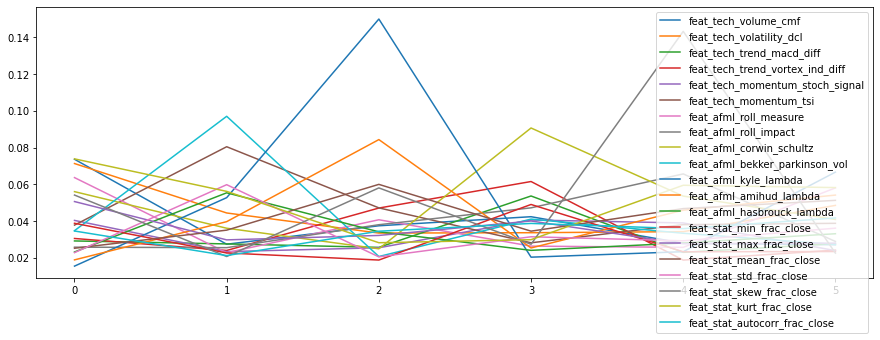

In [38]:
plt.figure(figsize=(15, 5))
for c in column_importance_ts.columns:
    plt.plot(column_importance_ts[c], label = c)
plt.legend()
plt.show()